In [73]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

import sys
sys.path.append("/home/jdli/transpec")

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

from tqdm import tqdm
import joblib 

from kvxp.kvxp2 import specformer2, CNN, inference
from kvxp.data import GXP_5lb, GXP_AP_4lb
from kvxp.vis import *

from matplotlib.colors import LogNorm
import cmasher as cmr
cmap = cmr.dusk

from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))

def mae(res):
    return np.median(np.abs(res))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
def recover_scale_label(y_hat, e_y_hat,
                        scaler_name='../docs/models/scaler_labels_0208.gz', 
                        bias=2, scale_ext=10):
    scaler_labels = joblib.load(scaler_name)
    
    y   = scaler_labels.inverse_transform(y_hat/scale_ext-bias)
    e_y = (e_y_hat * scaler_labels.scale_)/scale_ext
    return y, e_y


def infer_4lbs_model(model, data_loader, transcale_method=recover_scale_label,
                     model_type='attn', n_input=110, n_hi=7514, n_output=4, n_dim=128, 
                     n_head=8, n_layer=8, cnn_idx=(0,110), coef_mask=None,
                     device=torch.device('cuda:0'), 
                     mask_band=None):
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            if model_type == 'attn':
                x = data['x']
                
                if mask_band == 'xp':
                    x[:, :n_input] = 0.
                elif mask_band == 'ap':
                    x[:, n_input:] = 0
                else: 
                    x = x
                # output = inference(model, x, coef_mask, device)
                output = model(x, inf=True)
                
            elif model_type == 'cnn':
                x = data['x'][:, cnn_idx[0]:cnn_idx[1]]
                output = model(x)
                # print(x.shape)
                
            out_lst   = np.append(out_lst,  output[:,:4].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    y, e_y = transcale_method(out_lst, out_lst)
    return {'labels':y, 'source_id':id_lst}


In [146]:
import os

spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
ava_spec_names = os.listdir(spec_dir)
print(len(ava_spec_names))

115657


In [3]:
data_dir = "/data/jdli/gaia/"

gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")

# tr_file = "ap17_wise_xp_66701_allstand1225.npy"
tr_file = "ap_xp_13286.npy"


device = torch.device('cuda:1')
# device = torch.device('cpu')
TOTAL_NUM = 6000
BATCH_SIZE = int(2**4)

gdata  = GXP_AP_4lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=BATCH_SIZE)

# gdata[0]

x = gdata[0]['x'].cpu()

In [139]:
len(gdata)

13286

In [135]:
def remove_prefix(state_dict, unwanted_prefix = '_orig_mod.'):

    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            
    return state_dict

preflix_name = "sp2_4l_{:d}_ep{:d}.pt"
model_dirs = [data_dir + "model/0211_ap/", 
              data_dir + "model/0211_xp/",
              data_dir + "model/0214_apxp/",]
              # data_dir + "model/0213_apxp/"]

model_names = [model_dirs[i]+preflix_name.format(*[0,150]) for i in range(3)]

print(model_names)


['/data/jdli/gaia/model/0211_ap/sp2_4l_0_ep150.pt', '/data/jdli/gaia/model/0211_xp/sp2_4l_0_ep150.pt', '/data/jdli/gaia/model/0214_apxp/sp2_4l_0_ep150.pt']


In [136]:
###### from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

n_enc = 110
n_hi = 7514
n_outputs = 4
n_dim = 32
n_head = 4
n_layer = 2

N_model = 3
rdfs      = pd.DataFrame()
coef_masks = [None, None, 
              torch.arange(108, 386, 1, device=device),
              torch.arange(0,   108,  1, device=device)]
# coef_masks = [None, None, None, None]

pred_names   = ['teff', 'logg',  'moh', 'aom']
pred_names_preflix = [':AP', ':XP', ':XPAP_MaskAP']

mask_bands = [None, None, 'ap', 'xp']
# mask_bands = [None, None, None, None]
model_types = ['cnn', 'cnn', 'attn', 'attn']
cnn_idxs = [(n_enc, n_enc+n_hi), (0, n_enc), None, None]

# mask_ = [False, False, True, True]


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        
        
        for i in range(N_model):
            
            if i<=1:
                model = CNN(n_input=cnn_idxs[i][1]-cnn_idxs[i][0], 
                            n_output=4).to(device)
            else:
                model = specformer2(n_enc, n_outputs).to(device)

            tr_dict = torch.load(model_names[i])
            tr_dict = remove_prefix(tr_dict)
            model.load_state_dict(tr_dict)

            labels_infer = infer_4lbs_model(
                model, val_loader, device=device, 
                n_input=n_enc, 
                transcale_method=recover_scale_label,
                mask_band=mask_bands[i], model_type=model_types[i],
                cnn_idx=cnn_idxs[i], coef_mask=coef_masks[i]
            )

            rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['source_id']], 
                               columns=[p + pred_names_preflix[i] for p in pred_names]+['source_id'])
            
            rdfs = rdf if i==0 else pd.merge(rdfs, rdf, on='source_id')

            print(rdfs.shape)

FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 298.55it/s]


(2658, 5)


100%|████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 401.87it/s]


(2658, 9)


100%|█████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 83.56it/s]

(2658, 13)


In [137]:
gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")
rdf_val = rdfs.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))



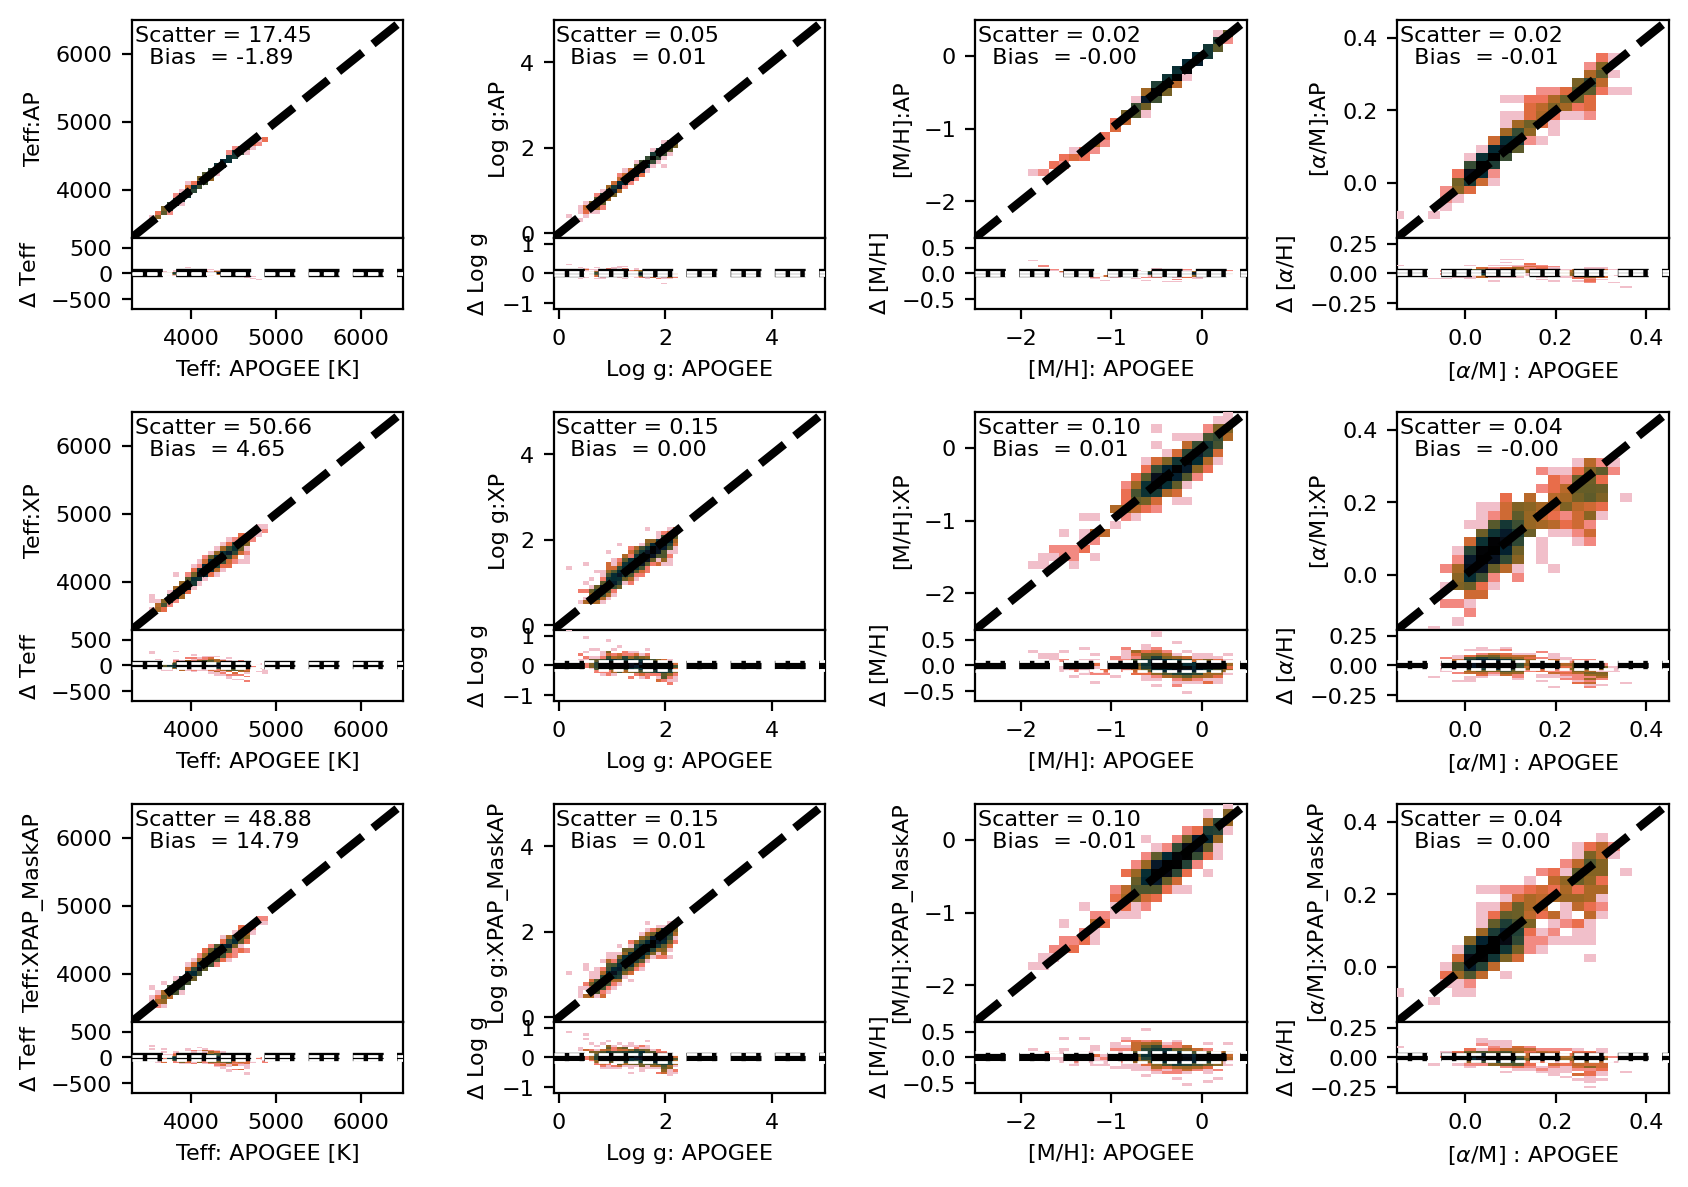

In [138]:
rcParams["font.size"] = 8

fig, axs = plt.subplots(N_model,4, figsize=(8.5, 2*N_model))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']

y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]


for j in range(N_model):
    
    for i in range(4):
        ynames = [p + pred_names_preflix[j] for p in pred_names]

        ax1, ax2 = draw_hist2d(
            axs[j,i], rdf_val[true_names[i]], rdf_val[ynames[i]],
            xrange=xranges[i], bins=20,
        )
        
        ylabel = [p + pred_names_preflix[j] for p in ylabels]
        
        ax1.set_ylabel(ylabel[i]);
        ax1.set_xticks([]);

        ax2.set_xlabel(xlabels[i]);
        ax2.set_ylabel(y2labels[i]);
        ax2.set_ylim(yranges[i]);

        
plt.tight_layout()